I will use this notebook to demonstrate some calculations of photon emission properties from a nanofiber-trapped neutral atom system using MEEP and plotting in Julia.

In [1]:
run(pipeline(`mpirun -n 6 meep-mpi "nanofiber.ctl"`, "nanofiber.out"))


Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecated features have been used.  Set the environment
variable GUILE_WARN_DEPRECATED to "detailed" and rerun the
program to get more information.  Set it to "no" to suppress
this message.

Some deprecate

# Local field evolution

This should be obtained by setting up a point-monitor at the dipole position and append time-dependent field components in some short periods. 
The data is stored in the `nanofiber-Ert.h5` file.
Now we plot out the time-dependent evolution of the field at the dipole position.

In [2]:
run(`h5ls nanofiber-Ert.h5`)

ex.i                     Dataset {1200/Inf}
ex.r                     Dataset {1200/Inf}
ey.i                     Dataset {1200/Inf}
ey.r                     Dataset {1200/Inf}
ez.i                     Dataset {1200/Inf}
ez.r                     Dataset {1200/Inf}


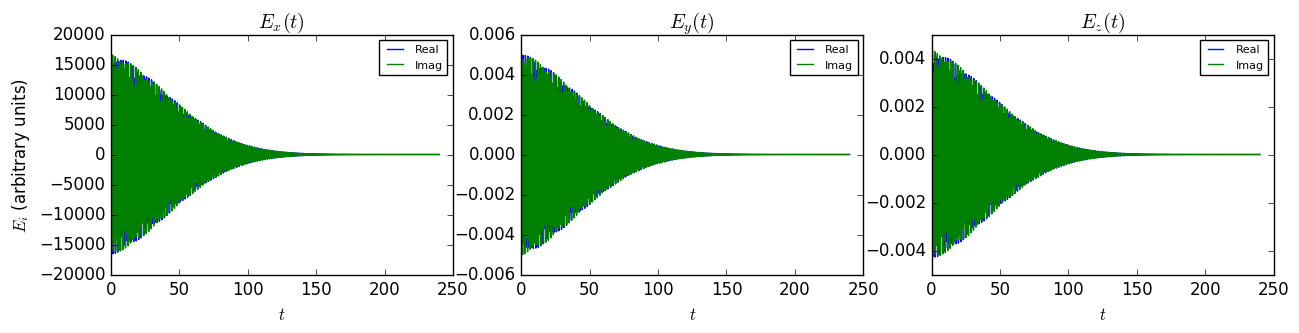

1
(1200,)


6.676845942248247e-16

In [5]:
using PyPlot
using HDF5
ex = h5read("nanofiber-Ert.h5", "ex.r") + im*h5read("nanofiber-Ert.h5", "ex.i")
ey = h5read("nanofiber-Ert.h5", "ey.r") + im*h5read("nanofiber-Ert.h5", "ey.i")
ez = h5read("nanofiber-Ert.h5", "ez.r") + im*h5read("nanofiber-Ert.h5", "ez.i")
println(ndims(ex)) # Print out the dimension of the variables to check if it's a vector (output 1). Otherwise, use permutedims to flip the data dimension.
ex = ex[end:-1:1]; ey = ey[end:-1:1]; ez = ez[end:-1:1];
println(size(ex))
lent=length(ex)
t=linspace(0,240.0,lent)
figure(figsize=(15,3))
subplot(1,3,1)
ax=plot(t,real(ex))
plot(t,imag(ex))
title("\$E_x(t)\$ ")
xlabel(L"t")
ylabel(L"$E_i$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,2)
ax=plot(t,real(ey))
plot(t,imag(ey))
title("\$E_y(t)\$")
xlabel(L"t")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

subplot(1,3,3)
ax=plot(t,real(ez))
plot(t,imag(ez))
title("\$E_z(t)\$")
xlabel(L"t")
#ylabel(L"$E_z$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

a=1.0e-6; c=2.99792458e8; t_unit=a/c;
deltaT=240.0*t_unit/(lent-1) # $\delta T$ in SI units. In MEEP, T is scaled by t_unit=a/c where a is the unit of length.

Now we can plot out the detected signal in the frequency domain correspondingly.

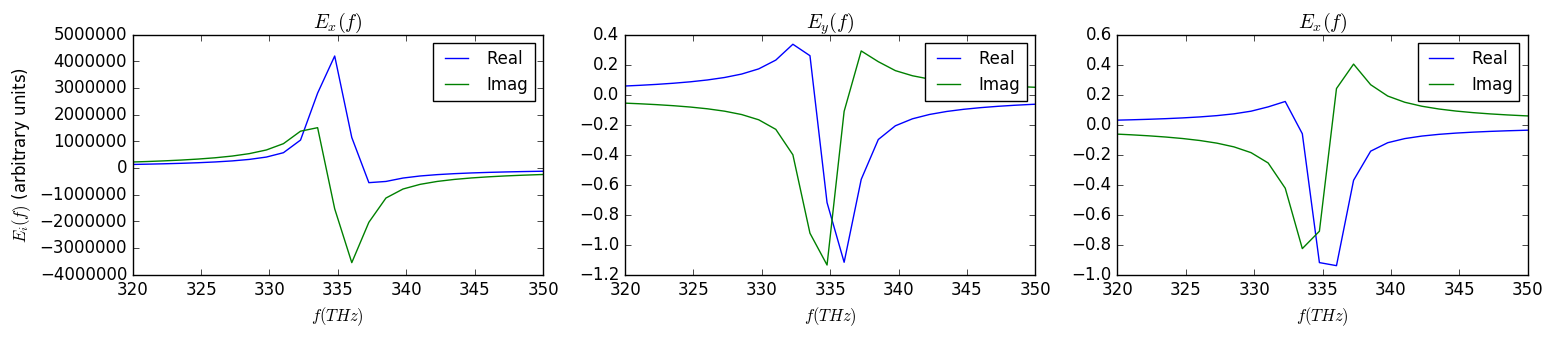

PyObject <matplotlib.legend.Legend object at 0x7f1bdf1f3dd0>

In [6]:
ex_f=fft(ex); ey_f=fft(ey); ez_f=fft(ez);
#ex_f=fftshift(ex_f); ey_f=fftshift(ey_f); ez_f=fftshift(ez_f); # Have to shift the frequency domain data for complex singal. See: http://www.exegetic.biz/blog/2015/10/monthofjulia-day-37-fourier-techniques/ 
freq_scale=linspace(0,1/deltaT,lent)/1e12;
figure(figsize=(18,3))
subplot(1,3,1)
plot(freq_scale,real(ex_f))
plot(freq_scale,imag(ex_f))
xlabel(L"f (THz)")
xlim([320,350])
ylabel(L"$E_i(f)$ (arbitrary units)")
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=12)

subplot(1,3,2)
plot(freq_scale,real(ey_f))
plot(freq_scale,imag(ey_f))
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
title("\$E_y(f)\$")
legend(["Real", "Imag"],fontsize=12)

subplot(1,3,3)
plot(freq_scale,real(ez_f))
plot(freq_scale,imag(ez_f))
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
title("\$E_x(f)\$")
legend(["Real", "Imag"],fontsize=12)

As we can see, the peak frequency is around $f_0=335THz$ or central wavelength at $\lambda_0=895nm$ which correctly corresponds to the input light signal. 

## The time-evolution of the dipole source
To calculate the Green function at the dipole position, we need to use the time-evolution of the dipole source which is essentially described by the following function
$$E_i = E_0 \exp{\left[-i\omega t-\frac{(t-t_0)^2}{2w^2}\right]},$$
where $w=\frac{1}{df}$ is the time width of the signal and $df$ is the frequency width in the special units defined by MEEP. In the simulation script, the center of time $t_0$ is defined by 
$t_0=t_{start}+\Delta t_{cutoff}$ with the starting time $t_{start}=0$ and the cutoff time $t_{cutoff}=5$ by default. So, the signal of the input component will look like the following.

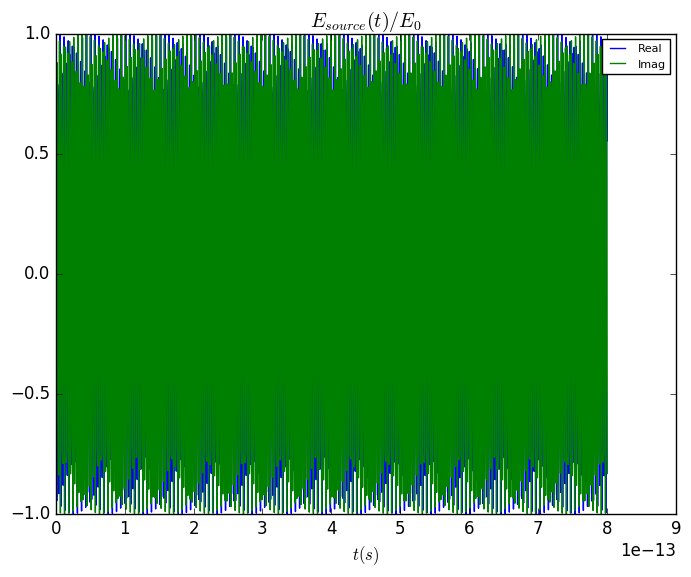

PyObject <matplotlib.legend.Legend object at 0x7f1bded78e50>

In [8]:
df=deltaT; w=1/df;
lambda0=0.895e-6;
ω=2.*pi*c/lambda0 
t_cutoff=5*t_unit; t_0=t_cutoff;
t=t*t_unit;
E_source=exp(-im*ω*t-(t-t_0).^2/2./w^2)
figure;
plot(t,real(E_source))
plot(t,imag(E_source))
title("\$E_{source}(t)/E_0\$")
xlabel(L"t(s)")
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=8)

Now, let's look at the signal in the frequency domain.

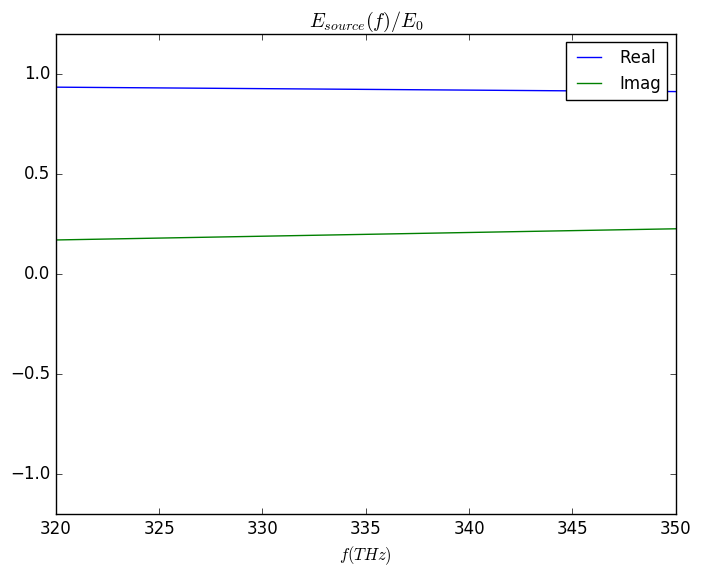

PyObject <matplotlib.legend.Legend object at 0x7f1bdb318510>

In [15]:
E_source_f = fft(E_source)
#E_source_f = fftshift(E_source_f) # Shift the data as before.
figure;
plot(freq_scale,real(E_source_f))
plot(freq_scale,imag(E_source_f))
title("\$E_{source}(f)/E_0\$")
xlabel(L"f (THz)")
xlim([320,350])
ylim([-1.2,1.2])
#ylabel(L"$E_y$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

The signal in MEEP is a complex function and is different from many other software. 

To be double checked.

## The Green's function and decay rates
We can calculate the Green's function in the frequency domain using the detected field and signal components obtained earlier. Only the imaginary part is related to us, and the Green's function we can obtain is normalized to the dipole excited in free space.

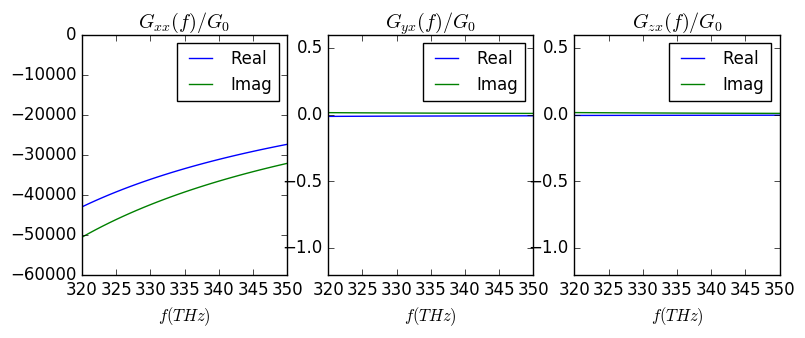

PyObject <matplotlib.legend.Legend object at 0x7f1bd9ab3b50>

In [26]:
Gxx=ex_f./E_source_f
Gyx=ey_f./E_source_f
Gzx=ez_f./E_source_f

figure(figsize=(9,3))
subplot(1,3,1)
plot(real(Gxx))
plot(imag(Gxx))
title("\$G_{xx}(f)/G_0\$")
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{xx}/G_0$ (arbitrary units)")
ylim([-60000,0])
legend(["Real", "Imag"],fontsize=12)
#legend(["Imag"],fontsize=8)

subplot(1,3,2)
plot(real(Gyx))
plot(imag(Gyx))
title("\$G_{yx}(f)/G_0\$")
xlabel(L"f(THz)")
xlim([320,350])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{yx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

subplot(1,3,3)
plot(real(Gzx))
plot(imag(Gzx))
title("\$G_{zx}(f)/G_0\$")
xlabel(L"f(THz)")
xlim([320,350])
#ylim([-10,10])
#xticks(linspace(800,960,5))
#ylabel(L"$G_{zx}/G_0$ (arbitrary units)")
legend(["Real", "Imag"],fontsize=12)

Above shows the local Green's function elements at the dipole position due to the dipole oscillating along x-direction. The values have a scaling problem which is due to the units of electric field defined in MEEP. Reference: http://meepunits.wikia.com/wiki/Meep_unit_transformation_Wiki and http://ab-initio.mit.edu/wiki/index.php/Meep_Introduction. It is also helpful to use a finer gridding scale in the simulation to obtain the accurate Purcell factor value since the FDTD method yields field components which may not be at the chosen place due to the way it meshes. 